In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [2]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


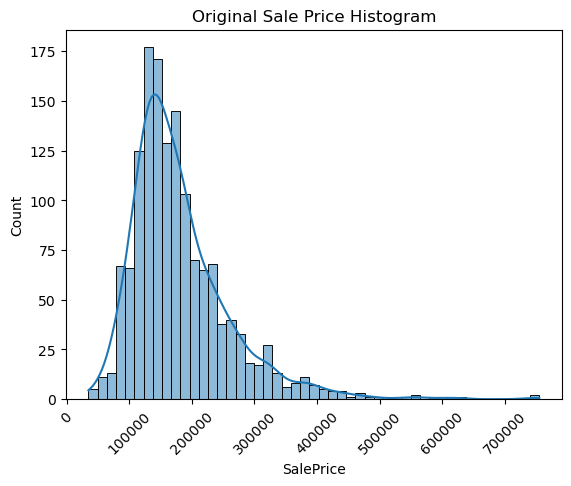

In [3]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

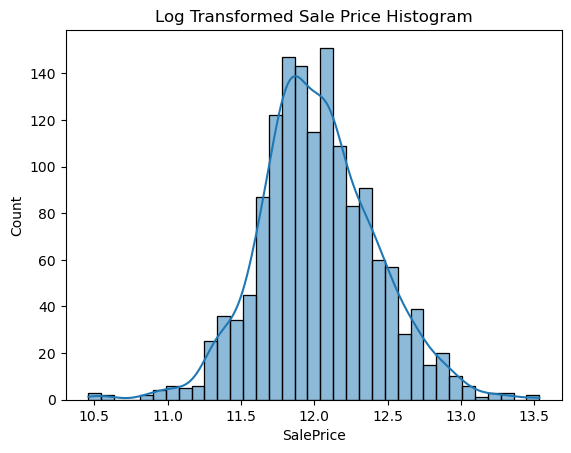

In [4]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrcie = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrcie, kde=True)
plt.show()

Null 값이 1천개가 넘는 상위 4개 컬럼 drop

In [5]:
# SalePrice 로그 변환
orginal_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

# 숫자형 null 칼럽은 평균값으로 대체
# house_df.fillna(house_df.mean(), inplace=True)
for column in house_df.columns:
    if house_df[column].dtype in ['int64', 'float64']:
        house_df[column].fillna(house_df[column].mean(), inplace=True)

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])


## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


One-Hot Encding(get_dummies)

In [6]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


선형 회귀 모델 학습/예측/평가

In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' 로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [9]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression  로그 변환된 RMSE: 0.132
Ridge  로그 변환된 RMSE: 0.127
Lasso  로그 변환된 RMSE: 0.176


[0.13183184688249705, 0.12740582836266132, 0.1762825055647141]

회귀 계수 값의 상위 10개 / 하위 10개

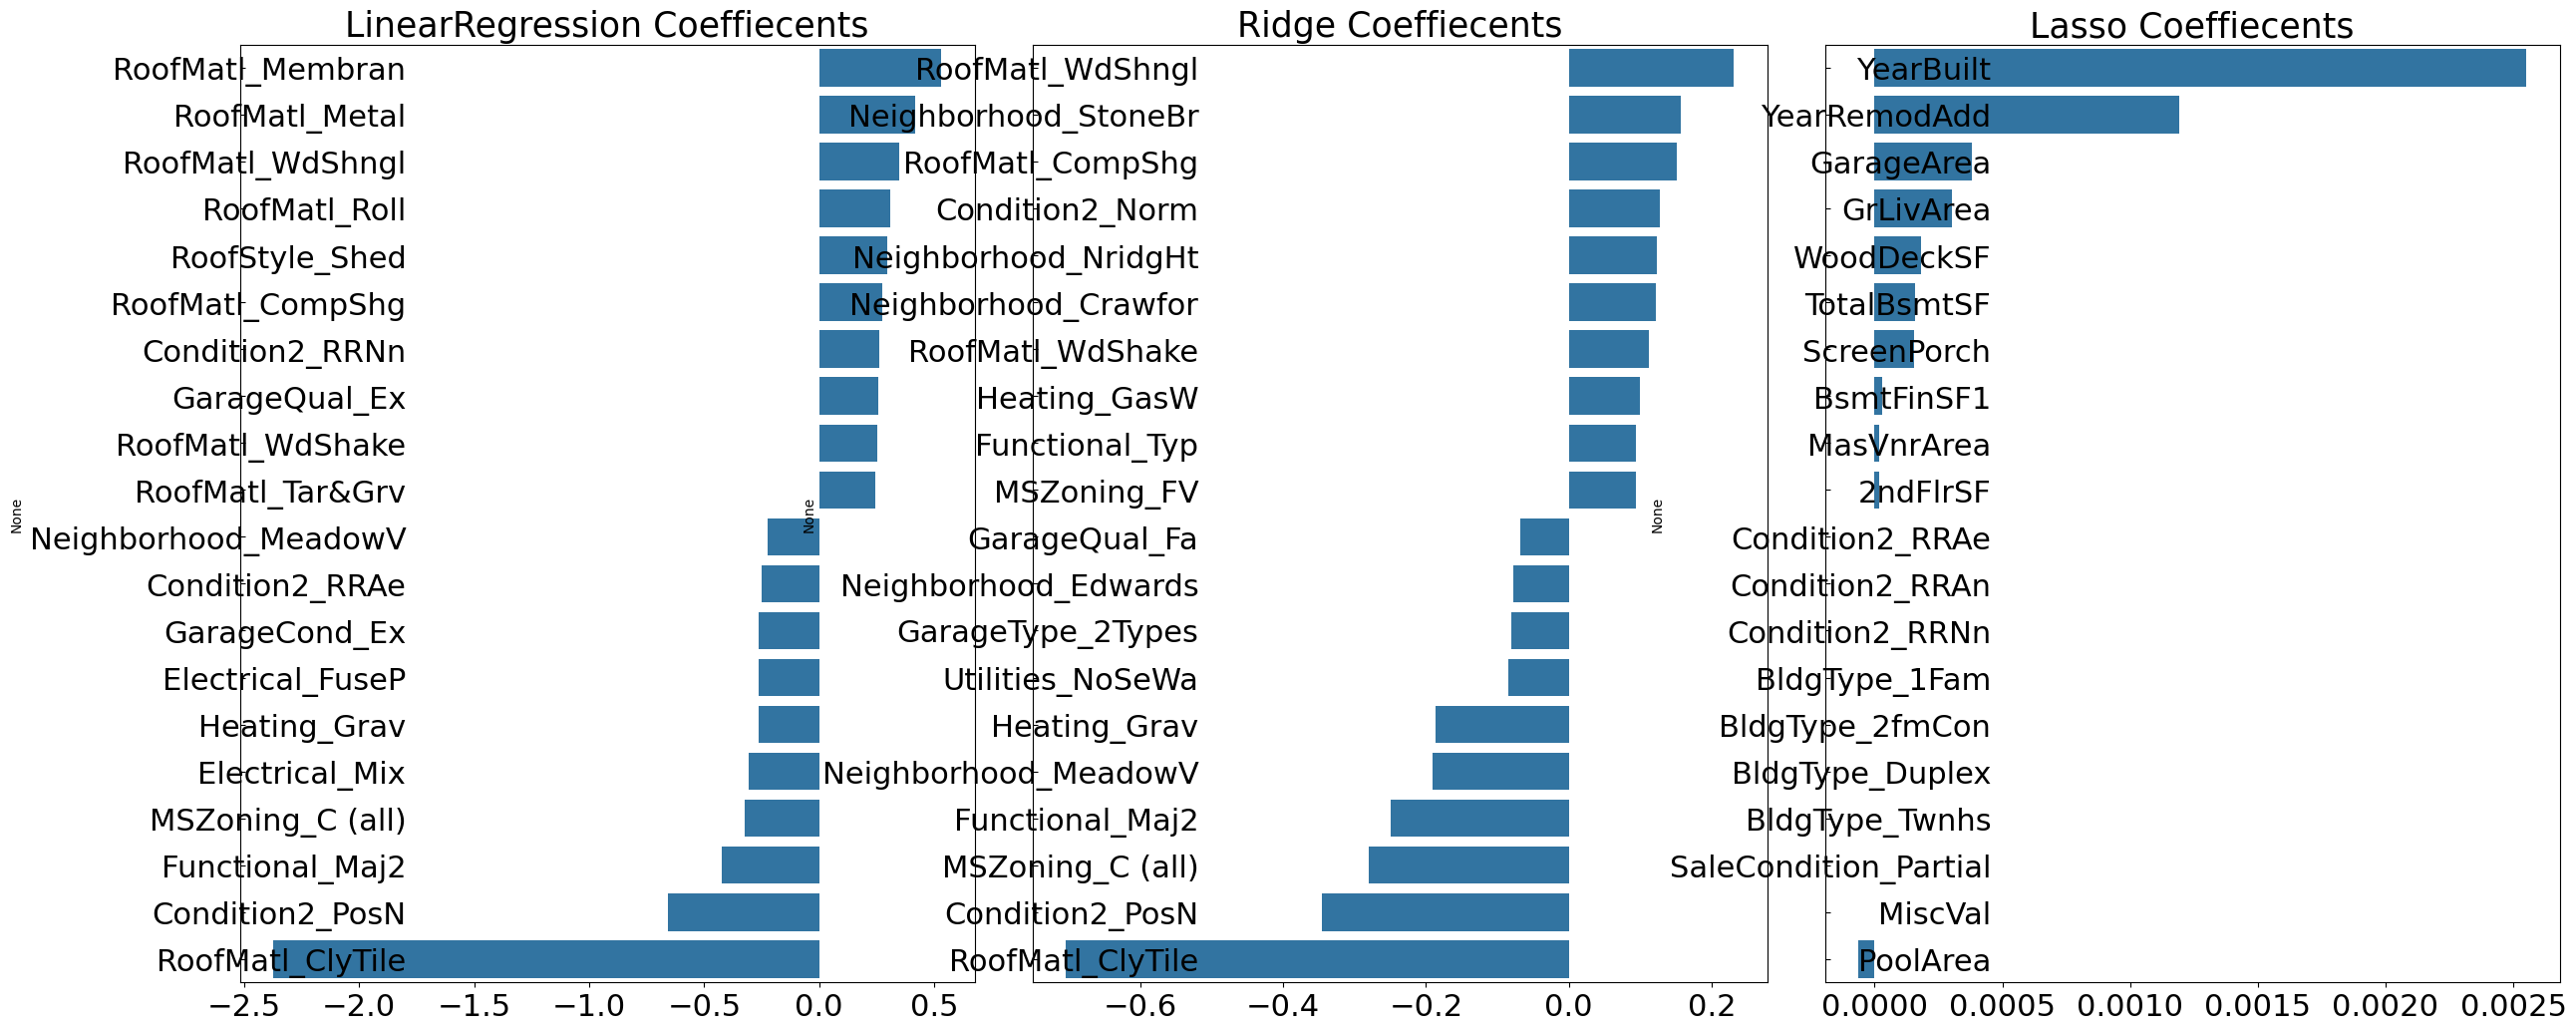

In [11]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()

    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

데이터 세트를 5개의 교차 검증 폴드 세트로 분할

In [12]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):

    for model in models:
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)

        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('\n{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)



Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]

Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]

Lasso CV 평균 RMSE 값: 0.198


하이퍼 파라미터 튜닝

In [14]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE {1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(rmse, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 0.142, 최적 alpha:{'alpha': 0.001}


LinearRegression  로그 변환된 RMSE: 0.132
Ridge  로그 변환된 RMSE: 0.124
Lasso  로그 변환된 RMSE: 0.12


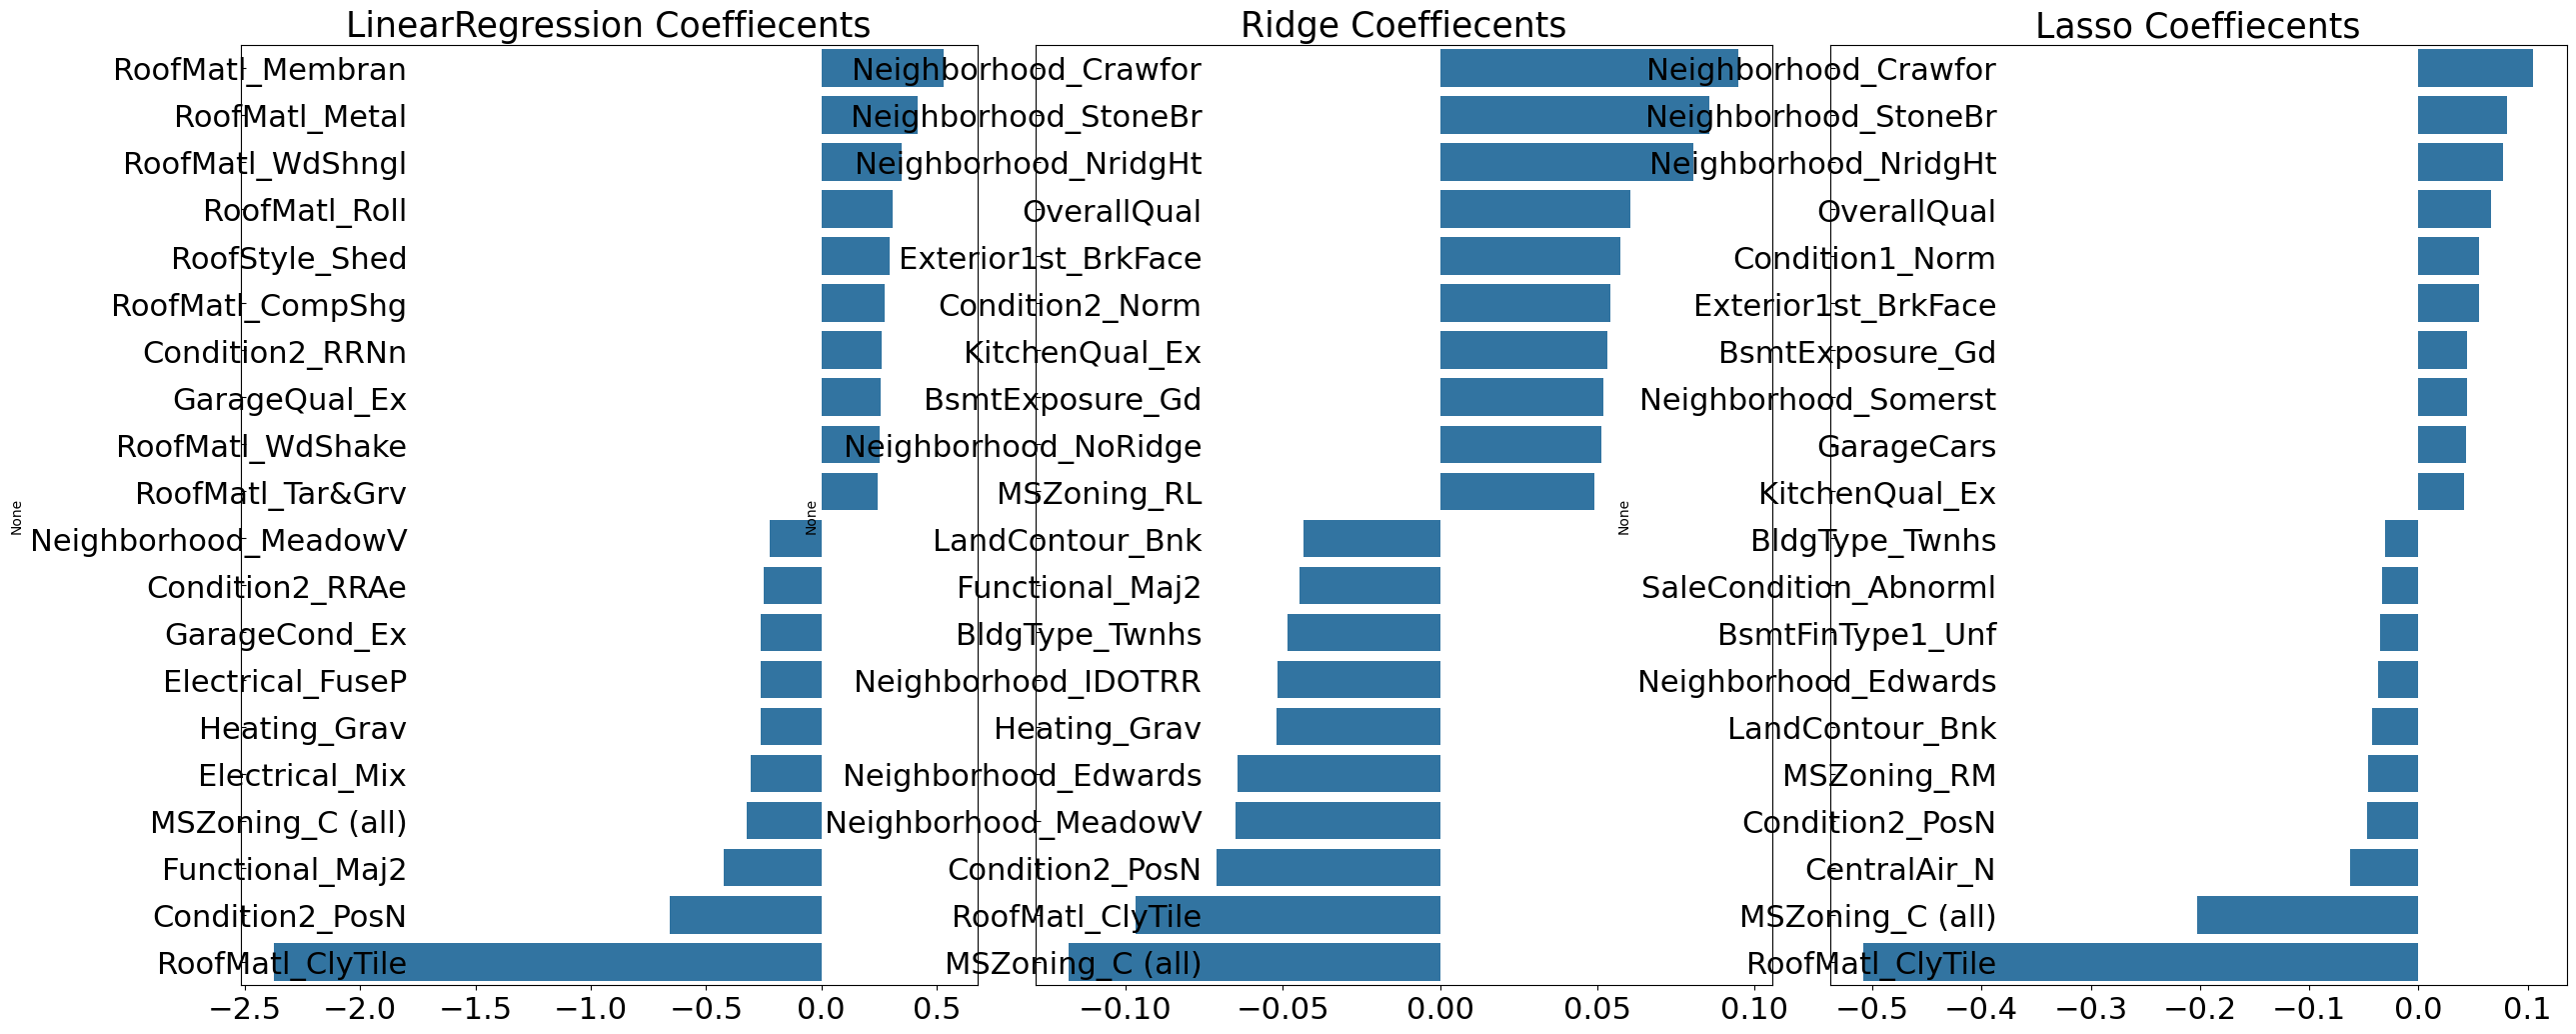

In [17]:
# 최적 파라미터
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

skew

In [18]:
from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes != 'object'].index
skew_features = house_df[features_index].apply(lambda x:skew(x))
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [ ]:
# 왜곡된 정도가 높은 피쳐들을 "로그 변환"
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [20]:
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 0.1252, 최적 alpha:{'alpha': 0.001}


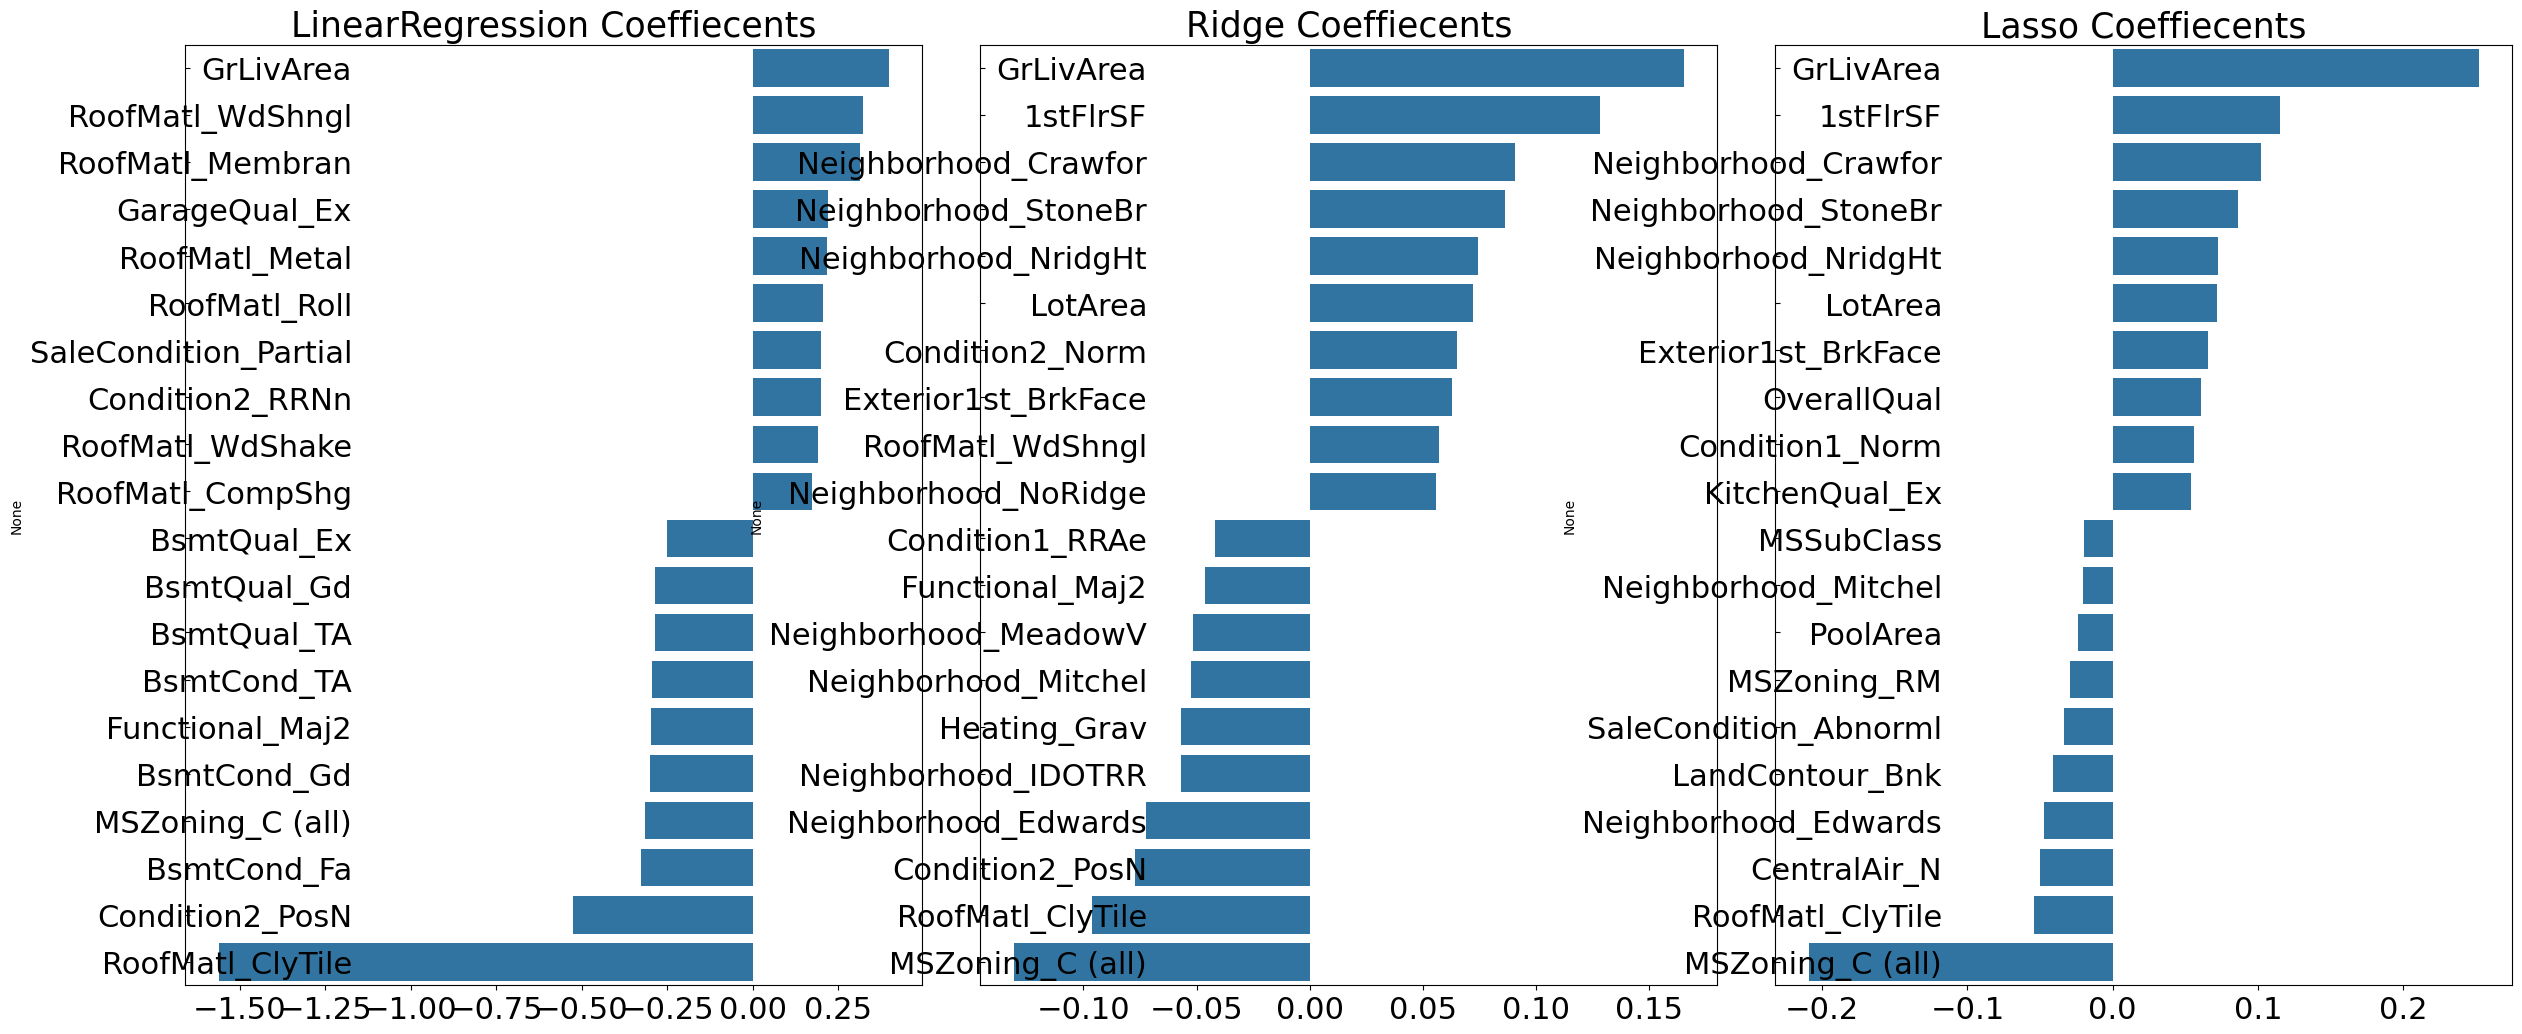

In [ ]:
# 변경된 alpha 값 적용
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

이상치 데이터

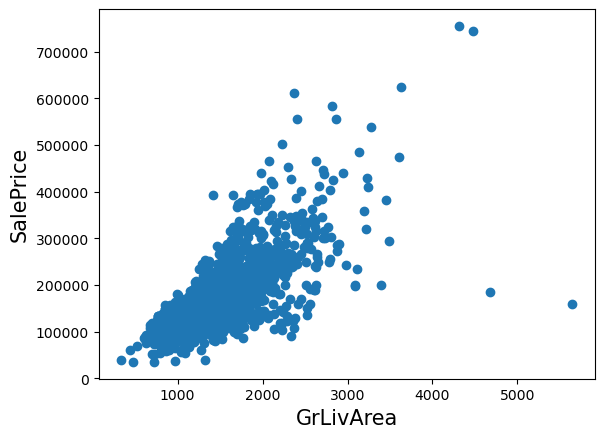

In [25]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [26]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shpae : ', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe shape : ', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shpae :  (1460, 270)
이상치 삭제 후 house_df_ohe shape :  (1458, 270)


In [27]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 0.1122, 최적 alpha:{'alpha': 0.001}


회귀에 중요한 영향을 미치는 피처 위주로 이상치 데이터를 찾으려는 노력은 중요하다

LinearRegression  로그 변환된 RMSE: 0.129
Ridge  로그 변환된 RMSE: 0.103
Lasso  로그 변환된 RMSE: 0.1


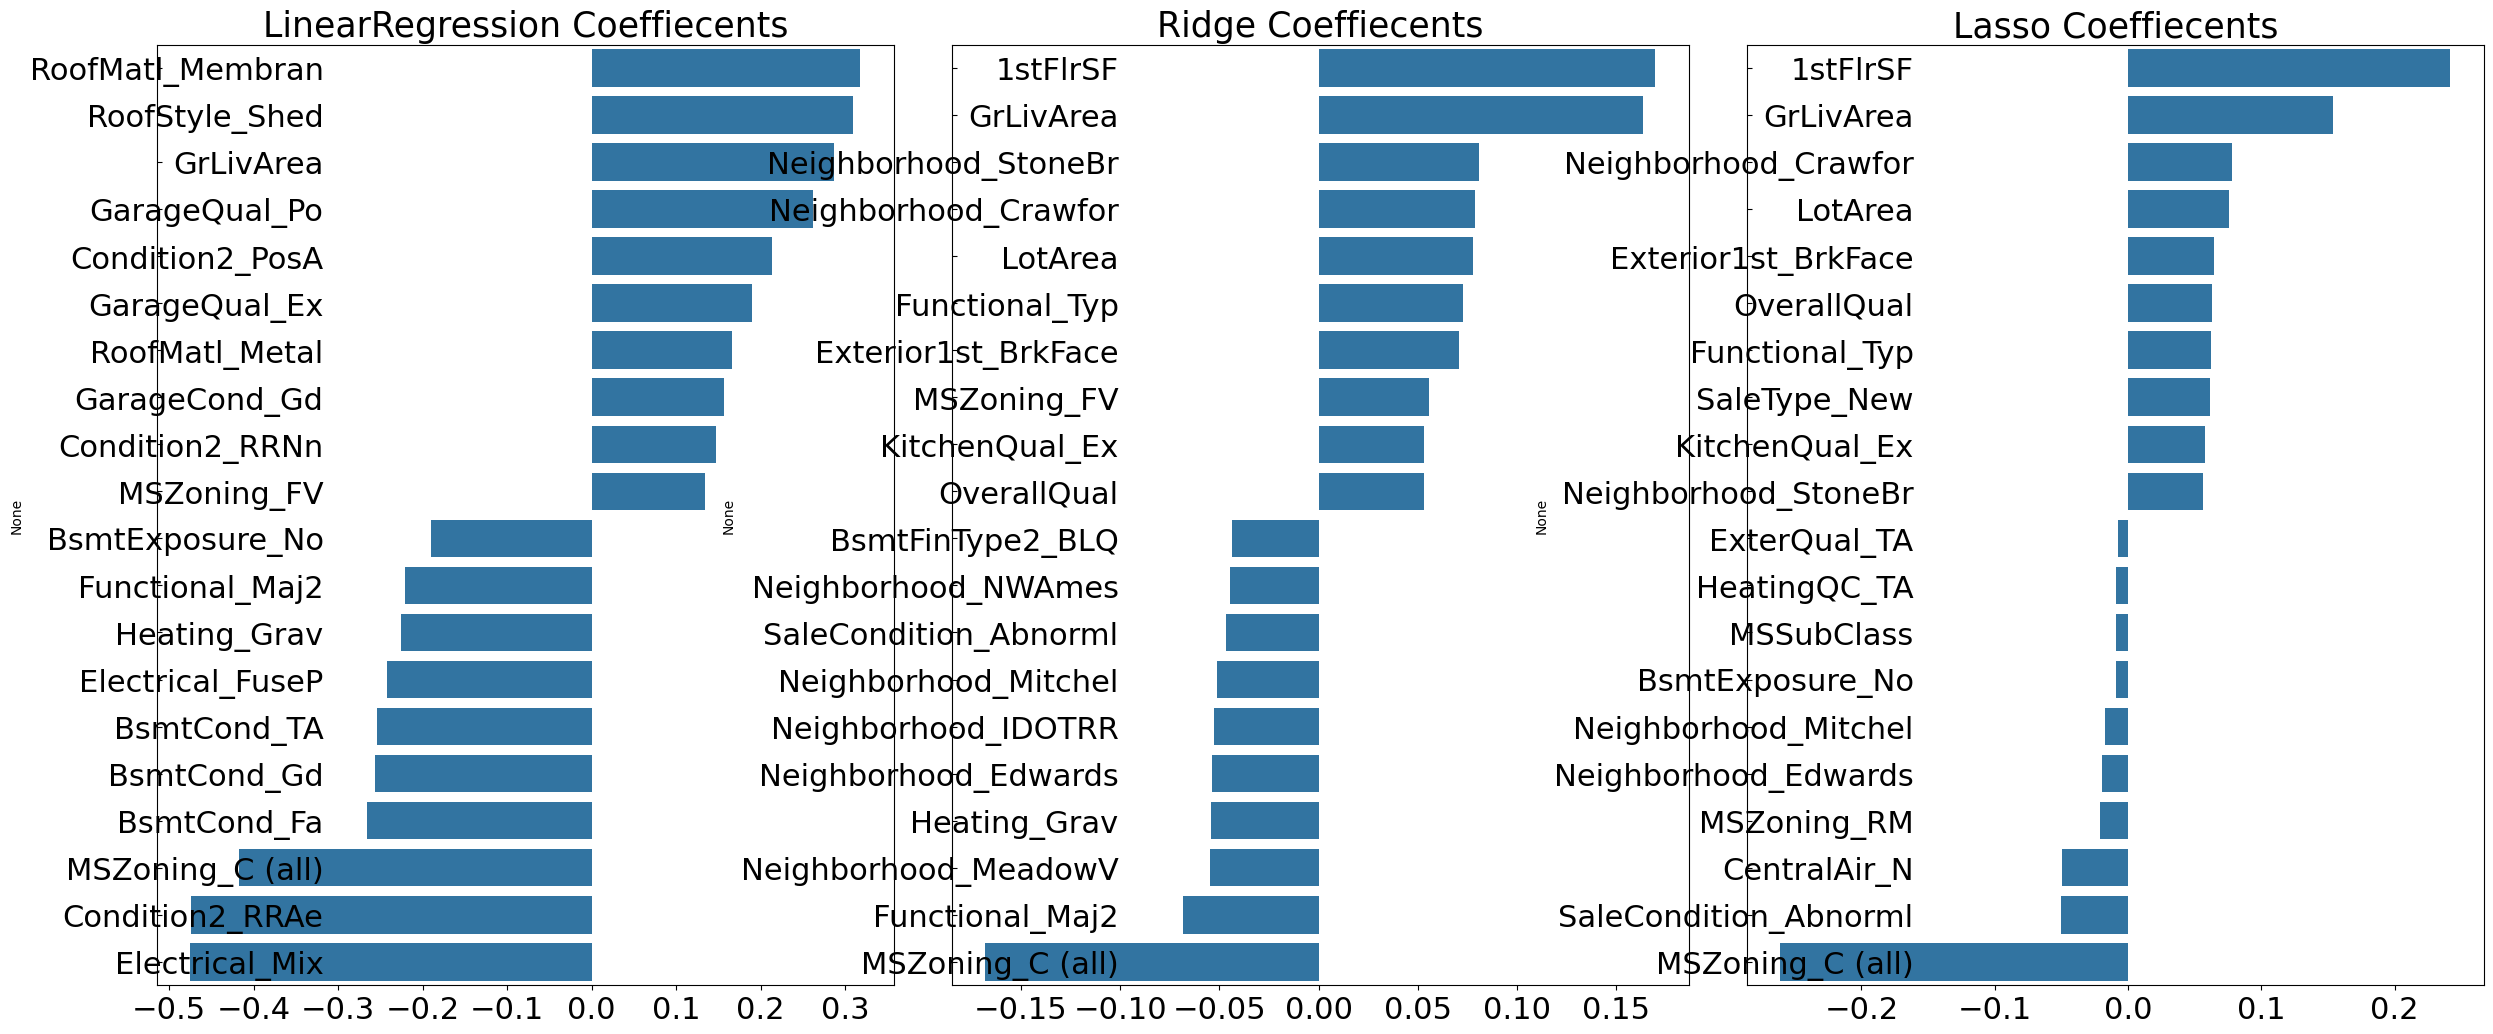

In [30]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

회귀트리

In [ ]:
from xgboost import RGB

xgb_params = {'n_estimatores':[1000]}
xgb_reg = XGBRegressor(n_es)

In [ ]:
from lightgbm import LGBREgressor